In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
# load vgg16 model
model = VGG16()

# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
BASE_DIR = './Flicker8k_Dataset'
# extract features from image
features = {}
#directory = os.path.join(BASE_DIR, '/Flicker8k_Dataset')

for img_name in tqdm(os.listdir("./Flickr8k_Dataset/Flicker8k_Dataset/")):
    # load the image from file
    img_path = "./Flickr8k_Dataset/Flicker8k_Dataset" + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [3]:
WORKING_DIR = "./"
# store features in pickle
# pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [4]:
with open(os.path.join('./Flickr8k_Dataset/', 'Flickr8k.token.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()
    
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [5]:
len(mapping)
# print(mapping)

8091

In [6]:
# before cleaning
mapping['3086523890_fd9394af8b']

['A big brown dog plays with a small white dog near a ball .',
 'A brown dog is jumping on top of a smaller white dog and there is a colorful ball on the floor .',
 'A large brown and a small white dog play indoors on a carpet .',
 'The fat brown dog is standing over the little white dog .',
 'two dogs play together .']

In [5]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split()]) + ' endseq'
            captions[i] = caption

In [6]:

# preprocess the text
clean(mapping)
# after preprocess of text
mapping['3086523890_fd9394af8b']

['startseq a big brown dog plays with a small white dog near a ball . endseq',
 'startseq a brown dog is jumping on top of a smaller white dog and there is a colorful ball on the floor . endseq',
 'startseq a large brown and a small white dog play indoors on a carpet . endseq',
 'startseq the fat brown dog is standing over the little white dog . endseq',
 'startseq two dogs play together . endseq']

In [7]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        
print("Total captions- ",len(all_captions))

# all_captions[:10]

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

print("Vocab size- ",vocab_size)

# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
print("Max lentgth- ",max_length)



Total captions-  40455
Vocab size-  8496
Max lentgth-  39


In [8]:
# Train Test Split

image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

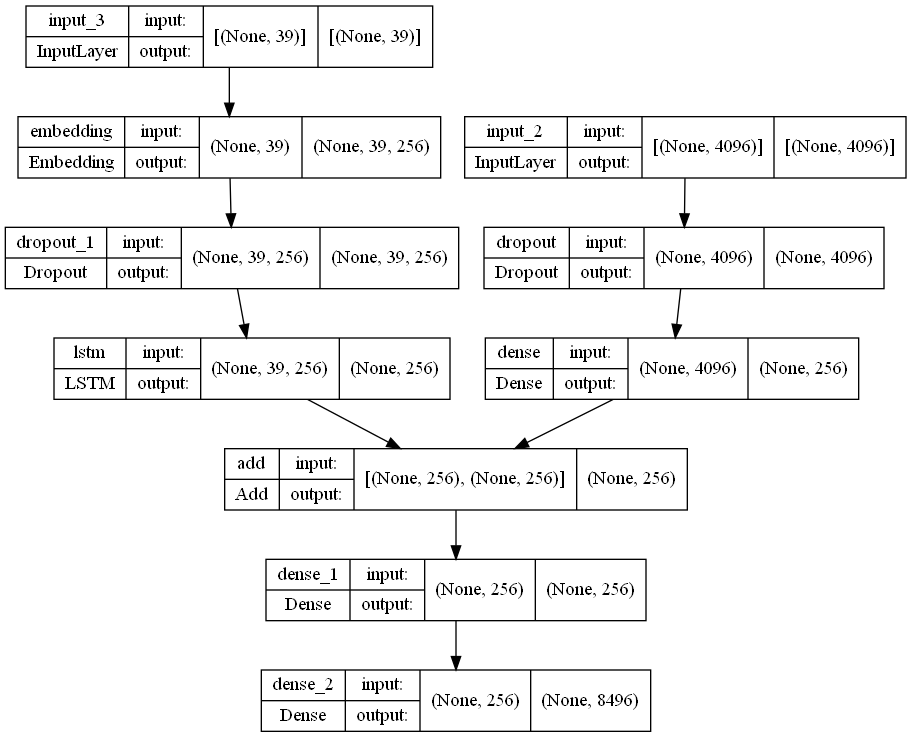

In [9]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [12]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 614s 3s/step - loss: 1.9611


In [13]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [10]:
# use the saved model
from keras.models import load_model

# Load the model
model = load_model(WORKING_DIR+'/best_model.h5')

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 39)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 39, 256)      2174976     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

In [11]:


def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

    
    

In [15]:
from nltk.translate.bleu_score import corpus_bleu


# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))



  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.574491
BLEU-2: 0.377103


In [12]:
#function for scaling external image

def extractFeatures(img_path):
    model1 = VGG16()

    # restructure the model
    model1 = Model(inputs=model1.inputs, outputs=model1.layers[-2].output)
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model1.predict(image, verbose=0)
    
    return feature

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
BASE_DIR = './Flickr8k_Dataset/'
WORKING_DIR = "./"
def generate_caption(image_name):
   
    

    # if image is from outside
    image_path = os.path.join(WORKING_DIR,image_name)
    image = Image.open(image_path)

    #extract features of input image
    ft_of_input = extractFeatures(image_path)

    # if image is from outside
    y_pred = predict_caption(model, ft_of_input, tokenizer, max_length)


    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    

    


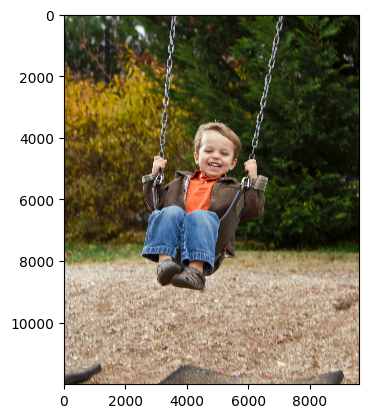

In [16]:
image = Image.open("./image4.jpg")
plt.imshow(image)

--------------------Predicted--------------------
startseq a man in a black jacket and a pink hat is walking through a field endseq


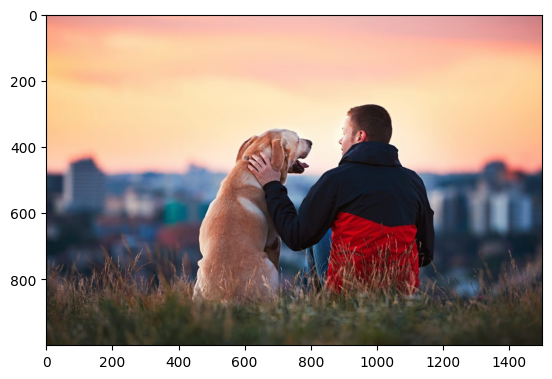

In [20]:
generate_caption("image1.jpg")

---------------------Actual---------------------
startseq a black dog and a spotted dog are fighting endseq
startseq a black dog and a tri-colored dog playing with each other on the road . endseq
startseq a black dog and a white dog with brown spots are staring at each other in the street . endseq
startseq two dogs of different breeds looking at each other on the road . endseq
startseq two dogs on pavement moving toward each other . endseq
--------------------Predicted--------------------
startseq two dogs play on a lawn endseq


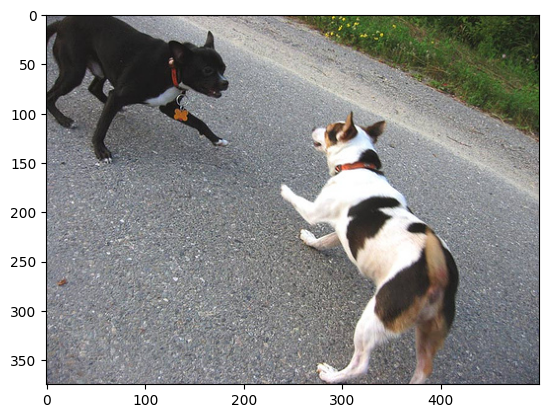

In [29]:
#image fron testing set
from PIL import Image
import matplotlib.pyplot as plt
BASE_DIR = './Flicker8k_Dataset'
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    image_path = os.path.join('./Flickr8k_Dataset/Flicker8k_Dataset/',image_id+'.jpg')
    image = Image.open(image_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    

    
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . endseq
startseq a little girl is sitting in front of a large painted rainbow . endseq
startseq a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . endseq
startseq there is a girl with pigtails sitting in front of a rainbow painting . endseq
startseq young girl with pigtails painting outside in the grass . endseq
--------------------Predicted--------------------
startseq a little girl in a yellow coat is climbing a rainbow rainbow rainbow candles endseq


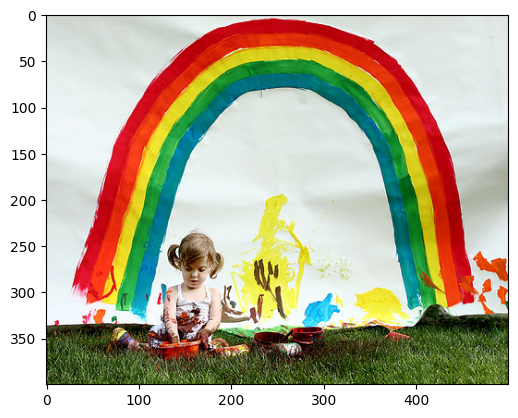

In [31]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq a man in a hat is displaying pictures next to a skier in a blue hat . endseq
startseq a man skis past another man displaying paintings in the snow . endseq
startseq a person wearing skis looking at framed pictures set up in the snow . endseq
startseq a skier looks at framed pictures in the snow next to trees . endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq a man skis down a frozen wall endseq


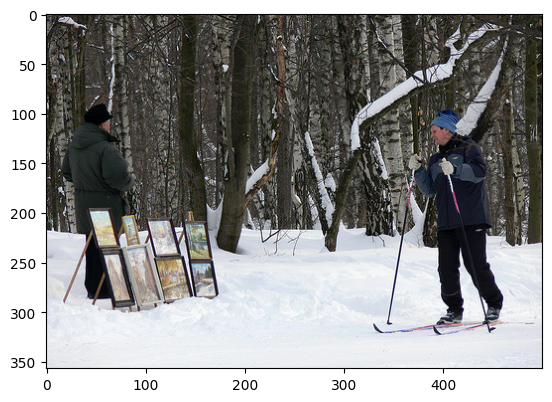

In [21]:
generate_caption("101669240_b2d3e7f17b.jpg")